**Sojeong Yang**
### CSC578 Final Project Part A: Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
import tensorflow as tf
from tensorflow.python.client import device_lib

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
print(tf.__version__)

2.3.1


### Load the weather dataset

In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
print(df.shape)
df.head()

(48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
date_time = pd.to_datetime(df.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

In [4]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


### Evolution of a few features over time:

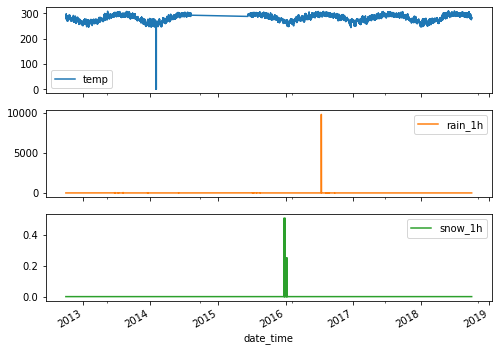

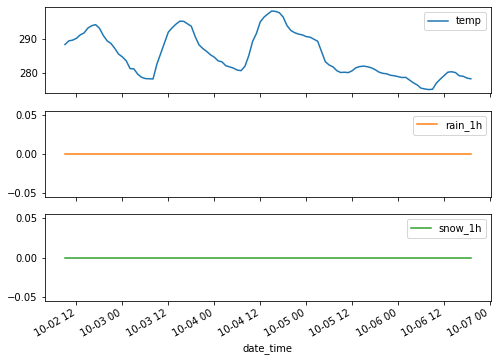

In [6]:
plot_cols = ['temp', 'rain_1h','snow_1h']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:100]
plot_features.index = date_time[:100]
_ = plot_features.plot(subplots=True)

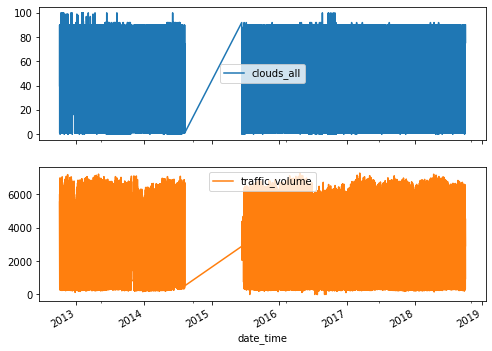

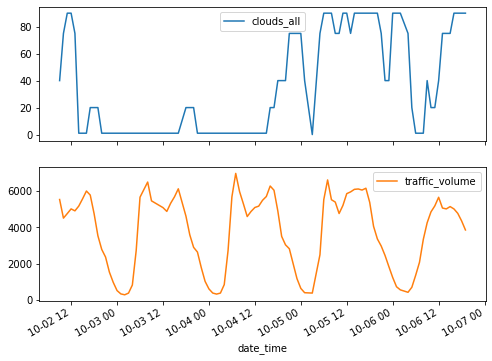

In [7]:
plot_cols = ['clouds_all', 'traffic_volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:100]
plot_features.index = date_time[:100]
_ = plot_features.plot(subplots=True)

### Inspect and clean up the Dataset

In [8]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


### Convert the Time format

In [9]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

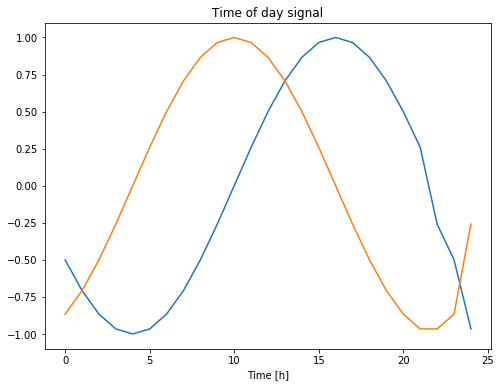

In [10]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

### Evaluate the most important frequency feacutes

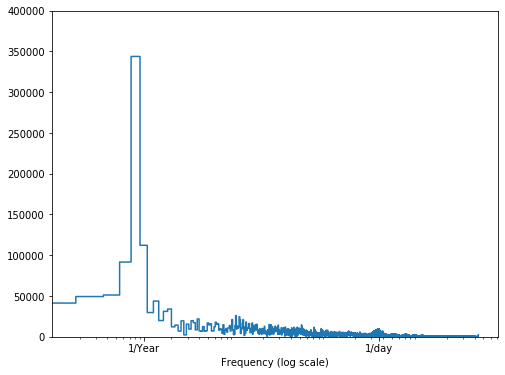

In [11]:
fft = tf.signal.rfft(df['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

> The highest peaks at frequencies near 1/year

### Change Categorical value to Numeric value

   #### `holiday` values transform to numeric values:

In [13]:
print("holiday categories:", df.holiday.unique())

holiday categories: ['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']


In [14]:
l_encoder = LabelEncoder()
holiday_labels = l_encoder.fit_transform(df['holiday'])

In [15]:
{index: label for index , label in enumerate(l_encoder.classes_)}

{0: 'Christmas Day',
 1: 'Columbus Day',
 2: 'Independence Day',
 3: 'Labor Day',
 4: 'Martin Luther King Jr Day',
 5: 'Memorial Day',
 6: 'New Years Day',
 7: 'None',
 8: 'State Fair',
 9: 'Thanksgiving Day',
 10: 'Veterans Day',
 11: 'Washingtons Birthday'}

In [16]:
df['holiday'] = l_encoder.fit_transform(df['holiday'])

#### `weather_main` categorical values transform to numeric values:

In [17]:
print("weather categories:", df.weather_main.unique())

weather categories: ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']


In [18]:
weather_main = l_encoder.fit_transform(df['weather_main'])

In [19]:
{index: label for index , label in enumerate(l_encoder.classes_)}

{0: 'Clear',
 1: 'Clouds',
 2: 'Drizzle',
 3: 'Fog',
 4: 'Haze',
 5: 'Mist',
 6: 'Rain',
 7: 'Smoke',
 8: 'Snow',
 9: 'Squall',
 10: 'Thunderstorm'}

In [20]:
df['weather_main'] = l_encoder.fit_transform(df['weather_main'])

#### `weather_description` categorical values transform to numeric values:

In [21]:
print("\nweather description categories:", df.weather_description.unique())


weather description categories: ['scattered clouds' 'broken clouds' 'overcast clouds' 'sky is clear'
 'few clouds' 'light rain' 'light intensity drizzle' 'mist' 'haze' 'fog'
 'proximity shower rain' 'drizzle' 'moderate rain' 'heavy intensity rain'
 'proximity thunderstorm' 'thunderstorm with light rain'
 'proximity thunderstorm with rain' 'heavy snow' 'heavy intensity drizzle'
 'snow' 'thunderstorm with heavy rain' 'freezing rain' 'shower snow'
 'light rain and snow' 'light intensity shower rain' 'SQUALLS'
 'thunderstorm with rain' 'proximity thunderstorm with drizzle'
 'thunderstorm' 'Sky is Clear' 'very heavy rain'
 'thunderstorm with light drizzle' 'light snow'
 'thunderstorm with drizzle' 'smoke' 'shower drizzle' 'light shower snow'
 'sleet']


In [22]:
weather_description = l_encoder.fit_transform(df['weather_description'])
{index: label for index , label in enumerate(l_encoder.classes_)}

{0: 'SQUALLS',
 1: 'Sky is Clear',
 2: 'broken clouds',
 3: 'drizzle',
 4: 'few clouds',
 5: 'fog',
 6: 'freezing rain',
 7: 'haze',
 8: 'heavy intensity drizzle',
 9: 'heavy intensity rain',
 10: 'heavy snow',
 11: 'light intensity drizzle',
 12: 'light intensity shower rain',
 13: 'light rain',
 14: 'light rain and snow',
 15: 'light shower snow',
 16: 'light snow',
 17: 'mist',
 18: 'moderate rain',
 19: 'overcast clouds',
 20: 'proximity shower rain',
 21: 'proximity thunderstorm',
 22: 'proximity thunderstorm with drizzle',
 23: 'proximity thunderstorm with rain',
 24: 'scattered clouds',
 25: 'shower drizzle',
 26: 'shower snow',
 27: 'sky is clear',
 28: 'sleet',
 29: 'smoke',
 30: 'snow',
 31: 'thunderstorm',
 32: 'thunderstorm with drizzle',
 33: 'thunderstorm with heavy rain',
 34: 'thunderstorm with light drizzle',
 35: 'thunderstorm with light rain',
 36: 'thunderstorm with rain',
 37: 'very heavy rain'}

In [23]:
df['weather_description'] = l_encoder.fit_transform(df['weather_description'])

In [24]:
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,Day sin,Day cos,Year sin,Year cos
0,7,288.28,0.0,0.0,40,1,24,5545,-0.500000,-8.660254e-01,-0.999682,0.025224
1,7,289.36,0.0,0.0,75,1,2,4516,-0.707107,-7.071068e-01,-0.999663,0.025941
2,7,289.58,0.0,0.0,90,1,19,4767,-0.866025,-5.000000e-01,-0.999645,0.026658
3,7,290.13,0.0,0.0,90,1,19,5026,-0.965926,-2.588190e-01,-0.999625,0.027374
4,7,291.14,0.0,0.0,75,1,2,4918,-1.000000,5.575167e-13,-0.999605,0.028091
5,7,291.72,0.0,0.0,1,0,27,5181,-0.965926,2.588190e-01,-0.999585,0.028807
6,7,293.17,0.0,0.0,1,0,27,5584,-0.866025,5.000000e-01,-0.999564,0.029524
7,7,293.86,0.0,0.0,1,0,27,6015,-0.707107,7.071068e-01,-0.999543,0.030240
8,7,294.14,0.0,0.0,20,1,4,5791,-0.500000,8.660254e-01,-0.999521,0.030956
9,7,293.10,0.0,0.0,20,1,4,4770,-0.258819,9.659258e-01,-0.999498,0.031673


### Split and Preprocessing the data

In [25]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_df.shape, val_df.shape, test_df.shape

((33742, 12), (9641, 12), (4821, 12))

In [26]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_df.shape, val_df.shape, test_df.shape

((33742, 12), (9641, 12), (4821, 12))

In [27]:
test_df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,Day sin,Day cos,Year sin,Year cos
43383,0.01425,-0.257736,-0.008384,-0.032549,-1.272123,-0.919844,1.215586,0.993964,-1.382719,0.382176,1.298589,-0.433937
43384,0.01425,-0.185437,-0.008384,-0.032549,-1.272123,-0.919844,1.215586,1.307275,-1.241186,0.722722,1.298312,-0.434905
43385,0.01425,-0.131771,-0.008384,-0.032549,-1.169220,-0.919844,1.215586,1.715483,-1.016039,1.015156,1.298035,-0.435874
43386,0.01425,-0.091521,-0.008384,-0.032549,-1.169220,-0.919844,1.215586,1.524685,-0.722621,1.239548,1.297757,-0.436842
43387,0.01425,-0.062453,-0.008384,-0.032549,-0.268819,-0.554707,0.885282,0.796639,-0.380929,1.380607,1.297478,-0.437810
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,0.01425,0.252088,-0.008384,-0.032549,0.631582,-0.554707,-1.536949,0.151942,-0.014249,1.428719,-1.512847,-0.070010
48200,0.01425,0.200659,-0.008384,-0.032549,1.017468,-0.554707,0.334775,-0.230659,0.352432,1.380607,-1.512857,-0.069004
48201,0.01425,0.198423,-0.008384,-0.032549,1.017468,2.731527,0.554977,-0.542965,0.694124,1.239548,-1.512866,-0.067998
48202,0.01425,0.150720,-0.008384,-0.032549,1.017468,-0.554707,0.334775,-0.898955,0.987541,1.015156,-1.512874,-0.066992


In [28]:
test_df[8:]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,Day sin,Day cos,Year sin,Year cos
43391,0.01425,-0.312893,-0.008384,-0.032549,-1.272123,-0.919844,1.215586,0.026919,0.987541,1.015156,1.296356,-0.441681
43392,0.01425,-0.334508,-0.008384,-0.032549,-1.272123,-0.919844,1.215586,-0.975776,1.212688,0.722722,1.296073,-0.442648
43393,0.01425,-0.332272,-0.008384,-0.032549,1.017468,-0.554707,0.334775,-1.212265,1.354222,0.382176,1.295790,-0.443615
43394,0.01425,-0.360596,-0.008384,-0.032549,-1.272123,-0.919844,1.215586,-1.328753,1.402496,0.016725,1.295507,-0.444582
43395,0.01425,-0.418733,-0.008384,-0.032549,-1.272123,-0.919844,1.215586,-1.410595,1.354222,-0.348725,1.295222,-0.445548
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,0.01425,0.252088,-0.008384,-0.032549,0.631582,-0.554707,-1.536949,0.151942,-0.014249,1.428719,-1.512847,-0.070010
48200,0.01425,0.200659,-0.008384,-0.032549,1.017468,-0.554707,0.334775,-0.230659,0.352432,1.380607,-1.512857,-0.069004
48201,0.01425,0.198423,-0.008384,-0.032549,1.017468,2.731527,0.554977,-0.542965,0.694124,1.239548,-1.512866,-0.067998
48202,0.01425,0.150720,-0.008384,-0.032549,1.017468,-0.554707,0.334775,-0.898955,0.987541,1.015156,-1.512874,-0.066992


In [29]:
idx = test_df[8:].index
idx

RangeIndex(start=43391, stop=48204, step=1)

### Data Windowing
#### 1. Indexes and offsets

In [107]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

#### 2. Split

In [108]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)
    
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [109]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### 3. Create Dataset

In [110]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        #shuffle=True,
        shuffle=False,
        batch_size=16) # batch_size: 1, 16, 32, 64, 128, 256
    
    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

### Set up window

In [112]:
wide_window = WindowGenerator(
    input_width=6, label_width=1, shift=3, # 6-hour input, 3-hour past the end of the window
    label_columns=['traffic_volume'])

wide_window

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [8]
Label column name(s): ['traffic_volume']

In [113]:
for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 6, 12)
Labels shape (batch, time, features): (16, 1, 1)


In [114]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  #optimizer = tf.optimizers.RMSprop(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

### Baseline Model

In [286]:
base_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [287]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', base_model(wide_window.example[0]).shape)

Input shape: (32, 6, 12)
Output shape: (32, 6, 1)


In [288]:
history = compile_and_fit(base_model, wide_window)

Epoch 1/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.5112 - mean_absolute_error: 0.5552 - val_loss: 0.4181 - val_mean_absolute_error: 0.4952
Epoch 2/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.4095 - mean_absolute_error: 0.4758 - val_loss: 0.3463 - val_mean_absolute_error: 0.4383
Epoch 3/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.3814 - mean_absolute_error: 0.4518 - val_loss: 0.3235 - val_mean_absolute_error: 0.4219
Epoch 4/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.3677 - mean_absolute_error: 0.4396 - val_loss: 0.3079 - val_mean_absolute_error: 0.4107
Epoch 5/300
1055/1055 [==============================] - 4s 3ms/step - loss: 0.3585 - mean_absolute_error: 0.4310 - val_loss: 0.2982 - val_mean_absolute_error: 0.4023
Epoch 6/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.3508 - mean_absolute_error: 0.4237 - val_loss: 0.2922 - val_mean_absolute_error: 0.395

Epoch 50/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2629 - mean_absolute_error: 0.3503 - val_loss: 0.2156 - val_mean_absolute_error: 0.3216
Epoch 51/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2622 - mean_absolute_error: 0.3497 - val_loss: 0.2151 - val_mean_absolute_error: 0.3211
Epoch 52/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2615 - mean_absolute_error: 0.3491 - val_loss: 0.2149 - val_mean_absolute_error: 0.3209
Epoch 53/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2608 - mean_absolute_error: 0.3485 - val_loss: 0.2144 - val_mean_absolute_error: 0.3204
Epoch 54/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2601 - mean_absolute_error: 0.3480 - val_loss: 0.2141 - val_mean_absolute_error: 0.3200
Epoch 55/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2595 - mean_absolute_error: 0.3475 - val_loss: 0.2139 - val_mean_absolute_error:

Epoch 99/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2408 - mean_absolute_error: 0.3330 - val_loss: 0.2076 - val_mean_absolute_error: 0.3128
Epoch 100/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2405 - mean_absolute_error: 0.3328 - val_loss: 0.2076 - val_mean_absolute_error: 0.3128
Epoch 101/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2402 - mean_absolute_error: 0.3325 - val_loss: 0.2075 - val_mean_absolute_error: 0.3128
Epoch 102/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2400 - mean_absolute_error: 0.3324 - val_loss: 0.2075 - val_mean_absolute_error: 0.3127
Epoch 103/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2397 - mean_absolute_error: 0.3322 - val_loss: 0.2074 - val_mean_absolute_error: 0.3127
Epoch 104/300
1055/1055 [==============================] - 3s 3ms/step - loss: 0.2394 - mean_absolute_error: 0.3320 - val_loss: 0.2075 - val_mean_absolute_e

In [289]:
base_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 6, 32)             5760      
_________________________________________________________________
dense_18 (Dense)             (None, 6, 1)              33        
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [290]:
val_performance = {}
performance = {}
IPython.display.clear_output()
val_performance['LSTM'] = base_model.evaluate(wide_window.val)
performance['LSTM'] = base_model.evaluate(wide_window.test, verbose=0)

302/302 [==============================] - 0s 1ms/step - loss: 0.2057 - mean_absolute_error: 0.3117


### Find the Best Model

In [115]:
# bidirectional LSTM model
lstm_model = tf.keras.models.Sequential([
   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,)),
#                                                        recurrent_dropout=0.1, 
#                                                        dropout=0.1,
#                                                         kernel_regularizer=tf.keras.regularizers.L2(1e-4))), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, )),
#                                                         kernel_regularizer=tf.keras.regularizers.L2(1e-4))), 
#                                                         recurrent_dropout=0.1)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, )),
#                                                        kernel_regularizer=tf.keras.regularizers.L2(1e-4))),
#                                                        recurrent_dropout=0.1)),
  
    tf.keras.layers.Dense(units=1)
])

In [116]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (16, 6, 12)
Output shape: (16, 6, 1)


In [117]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
2109/2109 [==============================] - 21s 10ms/step - loss: 0.3482 - mean_absolute_error: 0.4290 - val_loss: 0.2366 - val_mean_absolute_error: 0.3429
Epoch 2/50
2109/2109 [==============================] - 21s 10ms/step - loss: 0.2572 - mean_absolute_error: 0.3496 - val_loss: 0.1983 - val_mean_absolute_error: 0.3065
Epoch 3/50
2109/2109 [==============================] - 20s 10ms/step - loss: 0.2184 - mean_absolute_error: 0.3155 - val_loss: 0.1743 - val_mean_absolute_error: 0.2809
Epoch 4/50
2109/2109 [==============================] - 21s 10ms/step - loss: 0.1922 - mean_absolute_error: 0.2923 - val_loss: 0.1509 - val_mean_absolute_error: 0.2624
Epoch 5/50
2109/2109 [==============================] - 21s 10ms/step - loss: 0.1762 - mean_absolute_error: 0.2780 - val_loss: 0.1328 - val_mean_absolute_error: 0.2486
Epoch 6/50
2109/2109 [==============================] - 21s 10ms/step - loss: 0.1653 - mean_absolute_error: 0.2684 - val_loss: 0.1271 - val_mean_absolute_error:

In [118]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (None, 6, 64)             11520     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 6, 128)            66048     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 6, 128)            98816     
_________________________________________________________________
dense_5 (Dense)              (None, 6, 1)              129       
Total params: 176,513
Trainable params: 176,513
Non-trainable params: 0
_________________________________________________________________


In [119]:
val_performance = {}
performance = {}
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

603/603 [==============================] - 1s 2ms/step - loss: 0.1195 - mean_absolute_error: 0.2270


### Other models

**1D convnet + RNN**

In [87]:
lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, 
                           padding="causal", activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=1),
   
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

#     tf.keras.layers.LSTM(16, return_sequences=True, activation='relu'),
#     tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'), 
  
    tf.keras.layers.Dense(units=1)
])

**Stateful bidirectional LSTM model**

In [ ]:
# lstm_model = tf.keras.models.Sequential([
   
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, 
#                                                        recurrent_dropout=0.2,
#                                                        batch_input_shape=(1, 6, 12), stateful=True,)),
    
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, stateful=True)), 
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, stateful=True)),
  
#     tf.keras.layers.Dense(units=1)
# ])

**Stacked LSTM layers model**

In [ ]:
# lstm_model = tf.keras.models.Sequential([
   
#     tf.keras.layers.LSTM(64, return_sequences=True),
# #                          stateful=True,
# #                          batch_input_shape=(1, 6, 12)),  # match the batch size in 'make_dataset'
#     tf.keras.layers.LSTM(64, return_sequences=True),
# #                          stateful=True), 
      
#     tf.keras.layers.Dense(units=1)
# ])

In [88]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (16, 6, 12)
Output shape: (16, 6, 1)


In [89]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/100
2109/2109 [==============================] - 17s 8ms/step - loss: 0.3534 - mean_absolute_error: 0.4314 - val_loss: 0.2302 - val_mean_absolute_error: 0.3342
Epoch 2/100
2109/2109 [==============================] - 18s 9ms/step - loss: 0.2628 - mean_absolute_error: 0.3538 - val_loss: 0.1792 - val_mean_absolute_error: 0.2889
Epoch 3/100
2109/2109 [==============================] - 19s 9ms/step - loss: 0.2138 - mean_absolute_error: 0.3119 - val_loss: 0.1704 - val_mean_absolute_error: 0.2723
Epoch 4/100
2109/2109 [==============================] - 18s 8ms/step - loss: 0.1938 - mean_absolute_error: 0.2931 - val_loss: 0.1679 - val_mean_absolute_error: 0.2676
Epoch 5/100
2109/2109 [==============================] - 17s 8ms/step - loss: 0.1774 - mean_absolute_error: 0.2781 - val_loss: 0.1581 - val_mean_absolute_error: 0.2612
Epoch 6/100
2109/2109 [==============================] - 17s 8ms/step - loss: 0.1687 - mean_absolute_error: 0.2698 - val_loss: 0.1390 - val_mean_absolute_error:

In [90]:
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 6, 64)             3904      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 6, 128)            66048     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 6, 128)            98816     
_________________________________________________________________
dense_8 (Dense)              (None, 6, 1)              129       
Total params: 168,897
Trainable params: 168,897
Non-trainable params: 0
_________________________________________________________________


In [91]:
val_performance = {}
performance = {}
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

603/603 [==============================] - 1s 2ms/step - loss: 0.1274 - mean_absolute_error: 0.2322


**CuDNN model**

In [87]:
batch_size = 16
input_dim = 12

units = 16
output_size = 1  

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
        
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = tf.keras.models.Sequential(
        [
            lstm_layer,
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(output_size),
        ]
    )
    return model

In [88]:
cudnn_model = build_model(allow_cudnn_kernel=True)
history = compile_and_fit(cudnn_model, wide_window)

Epoch 1/100
2109/2109 [==============================] - 5s 2ms/step - loss: 0.5770 - mean_absolute_error: 0.6012 - val_loss: 0.6631 - val_mean_absolute_error: 0.6118
Epoch 2/100
2109/2109 [==============================] - 5s 2ms/step - loss: 0.4782 - mean_absolute_error: 0.5512 - val_loss: 0.5147 - val_mean_absolute_error: 0.5408
Epoch 3/100
2109/2109 [==============================] - 5s 2ms/step - loss: 0.4509 - mean_absolute_error: 0.5349 - val_loss: 0.5885 - val_mean_absolute_error: 0.5650
Epoch 4/100
2109/2109 [==============================] - 5s 2ms/step - loss: 0.4330 - mean_absolute_error: 0.5239 - val_loss: 0.6379 - val_mean_absolute_error: 0.5783


### Plot the model

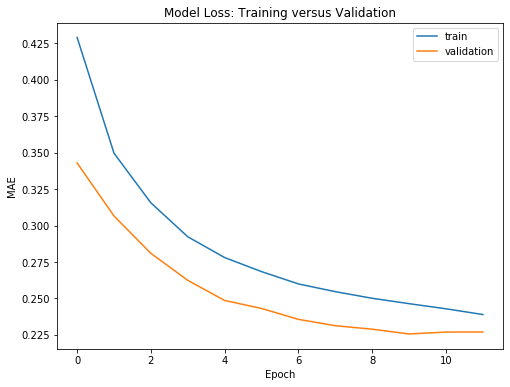

In [120]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.title('Model Loss: Training versus Validation')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [121]:
target = np.expand_dims(test_df, axis=0)
target.shape

(1, 4821, 12)

In [122]:
predictions = lstm_model.predict(target)
print(predictions.shape)

(1, 4821, 1)


In [123]:
predictions

array([[[ 0.98079664],
        [ 0.9825061 ],
        [ 1.0031459 ],
        ...,
        [-1.3915584 ],
        [-1.4099038 ],
        [-1.4298885 ]]], dtype=float32)

In [124]:
p = pd.DataFrame(np.concatenate(predictions))
p.head()

,0
0,0.980797
1,0.982506
2,1.003146
3,0.995604
4,0.989900


#### Denormalize result data

In [125]:
mean = train_mean['traffic_volume']
print("Mean:", mean)
std = train_std['traffic_volume']
print("Standardization:", std)

Mean: 3240.387854898939
Standardization: 1991.6329781952038


In [126]:
pred_denorm = []
for i in range(p.shape[0]):
    denorm = p[0][i]*std + mean  # denormalize) y = y'*std + mean
    pred_denorm.append(denorm)
    
#pred_denorm

In [127]:
pred = pd.DataFrame(pred_denorm)
pred = pred[8:]
pred.columns=['prediction']
pred.index = np.arange(0,len(pred))
print(pred.shape)
pred.head()

(4813, 1)


,prediction
0,5302.025884
1,5326.814315
2,5331.495073
3,5365.272743
4,5399.619036


In [128]:
pred.loc[:,'id'] = idx

In [130]:
cols = pred.columns.tolist()
cols = cols[-1:] + cols[:-1]
pred = pred[cols]

In [131]:
pred = pred.set_index('id')
pred

,prediction
id,
43391,5302.025884
43392,5326.814315
43393,5331.495073
43394,5365.272743
43395,5399.619036
...,...
48199,349.196520
48200,391.378899
48201,468.914237


In [100]:
#pred.to_csv('predictions19_includeCategory.csv')